# Lab 2: Errors

In Lab 1, we discussed the represenation of binary floating point numbers. One of the key results we discussed was the fact that there are only a finite number of bits, usually 64, used to store a floating point number.

Today, we're going to explore the often surprising consequences of this fact. First, we'll recall how digits are stored: in an IEEE single precision (32 bit) float, a number is represented as

$$(-1)^s 1.f 2^{e-B},$$

where the bias $B = 127$. For example,

| s | e | f|
|- | - | -|
| 0 | 10000010 | 01000000000000000000000|

What decimal number does this represent? Work it out on paper!

$$-1^0 * 1.25 * 2^{130-127} = 1.25 * 2^3 = 10$$

## Adding Floating point numbers

To begin to see how error creeps in just from our finite floating point representation, let's consider adding two numbers in regular, decimal scientific notation with bias $B= 0$. If we had say $7 + 3 \times 10^{-5}$, we can easily see the answer is $7.00003$. If we use double precision numbers (as python does by default), this poses no challenge to the computer either:

In [10]:
print('{:.27f}'.format(7+3e-5)) # I definetly see the rounding error

7.000003000000000419333900936


However, let's consider doing the same thing, but now we'll assume we have only 4 digits of precision in the mantissa of our numbers. That gives us $7.000$ and $3.000 \times 10^{-5}$. So far, so good. Floating point allows us to represent both of these quantities with the same number of digits of precision.

When we go to add them, the computer will do that by shifting the smaller number such that it has the same exponent of as the larger number, in this case $10^0$. Remember, we can represent the same number many ways--*but we must keep only 4 digits of precision*:

$3.000 \times 10^{-5} = 0.300 \times 10^{-4} = 0.030 \times 10^{-3} = 0.003 \times 10^{-2}$

You can see where this is going. We shift one more time, and we end up with $0.000 \times 10^{-1}$. This is not good, since this is zero, and we still have one more shift to do! We end up with

$7.000 \times 10^0 + 0.000 \times 10^0$ = $7.000 \times 10^0,$ which is clearly the wrong answer.

## Machine Precision

This leads us to a very important definition: there exists a number $\epsilon_m$ such that $1_c + \epsilon_m = 1_c$, where that subscript $c$ means "as represented on the computer" rather than "the mathematical object 1".

Let's find an approximation for $\epsilon_m$ experimentally. In doing so, we're going to meet another kind of loop, called the `while` loop. A `while` loop tests an expression at the top, just like an if statement. If the expression is true, then the loop body executes. If it is false, the loop stops. **Be careful! While loops may never stop!** This is sometimes what you want, but often not. You *must make sure* that the expression at the top changes! 

#### hint
If your while loop seems to never end, you can go to the `Kernel` menu in the Jupyter notebook and choose `Interrupt Kernel`. That should cause your code to stop and an error message to be printed. You can then fix your loop and restart. Any calculation like these ones should be more or less instantaneous. Later in the class, we'll have calculations that will take longer.

In [11]:
eps = 1.
test = 1. + eps
while test != 1.: # so this loop will run as long as test+eps is not exactly equal to one.
    eps = eps/2. # <---- here we *change* eps! 
    test = 1.+eps # <---- here we *change* test! 
print(eps)
print(test)

1.1102230246251565e-16
1.0


So what does this code do? How does it find epsilon? 

That expression above was using standard python floating point numbers, which are double precision. We can use `numpy` to create *single precision* numbers. Here's how:

In [14]:
import numpy as np
eps = np.float32(1.)
test = np.float32(1.) + eps

while test != np.float32(1.): 
    eps = eps/np.float32(2) 
    test = np.float32(1.)+eps  
print(eps)

5.9604645e-08


Note we have to be careful! Every number in python is double precision unless you say otherwise. Also, python is smart enough to automatically "promote" a variable like `eps` to double precision if you add, subtract, multiply, or divide by something of double precision. That's why I've carefully set all numbers to be `np.float32`s in the above cell.

### Questions

What is the difference in $\epsilon_m$ between single and double precision? Try to explain what is going on in terms of what you've learned about floating point numbers, comparing them to numbers written in scientific notation with a limited precision.

$\epsilon_m$ is clearly much larger in single precision. This makes sense as single preceision does not use as many bits and it is therefore $\epsilon_m$ does not have to be as small to get 'shifted off the mantissa'. Its easy to compare this to the concept of significant figures. Representing a number with single preceision is like having a smaller number of significant figures if we add a smaller number so that its smaller that what is significant in our other measurement we get the same measurement. With a smaller number of significant figures this of couse happens with a larger number. 

## Subtractive cancellation

By hand, subtract $5.324$ from $5.321$. How many digits of precision did you start with? How many did you end with? What does that tell you about your new answer? Think about these questions for a minute before proceeding.

This is called *subtractive cancellation*: you are cancelling off all of your more precise digits, and leaving only the least precise one (in this case). The subtraction you compute may be exact itself, but if there is any error in the starting values ($5.324$ and $5.321$) it becomes **amplified**. The technical term for this is "bad."

### Example 1

Calculate $y = \sqrt{x + 1} - \sqrt{x}$ for $x = 10^i$ with $i = 1,2,3,\ldots,20$. **Be careful:** you want $x$ to be a `float`, not an `int`. To do that make sure you use `10.**i` Store the answers in a numpy array called `y1`.

In [22]:
y1_ls = []
for i in range(1,21):
    y = (10.**i + 1)**(.5) - (10.**i)**(.5)
    y1_ls.append(y)

y1 = np.array(y1_ls)
print(y1)

[1.54347130e-01 4.98756211e-02 1.58074374e-02 4.99987501e-03
 1.58113488e-03 4.99999875e-04 1.58113879e-04 5.00000006e-05
 1.58113908e-05 4.99999442e-06 1.58115290e-06 5.00003807e-07
 1.57859176e-07 5.02914190e-08 1.86264515e-08 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


Now do the same thing, but get rid of the subtraction. Multiply $y$ by 

$$\frac{\sqrt{x + 1} + \sqrt{x}}{\sqrt{x + 1} + \sqrt{x}}$$

You should get a new expression for $y$ with no subtractions. Now, using your new formulation, calculate $y$ again, and store it in a new numpy array `y2`.

In [23]:
y2_ls = []
for i in range(1,21):
    y = 1 / ((10.**i + 1)**(.5) + (10.**i)**(.5))
    y2_ls.append(y)

y2 = np.array(y2_ls)
print(y2)

[1.54347130e-01 4.98756211e-02 1.58074374e-02 4.99987501e-03
 1.58113488e-03 4.99999875e-04 1.58113879e-04 4.99999999e-05
 1.58113883e-05 5.00000000e-06 1.58113883e-06 5.00000000e-07
 1.58113883e-07 5.00000000e-08 1.58113883e-08 5.00000000e-09
 1.58113883e-09 5.00000000e-10 1.58113883e-10 5.00000000e-11]


Clearly the second result is more accurate-- in the first result we even lost all of our precision and got 0 for the last few calculations. This makes sense as we aren't subtracting very similar numbers and losing our most precise digits. 

Which one of these is more accurate? If it's not obvious, you probably made a coding mistake.

The less accurate one is called *unstable*. The errors caused by subtractive cancellation *grow* as you move to certain values of $x$, in this case, large values.

Now using `pyplot`, plot the answer with subtraction `y1` and the answer without subtraction `y2` as a function of `x`. Code to do this is in the cell below. Look at the code and see the sytle of the plot.

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

x = [10.**i for i in range(1,21)]

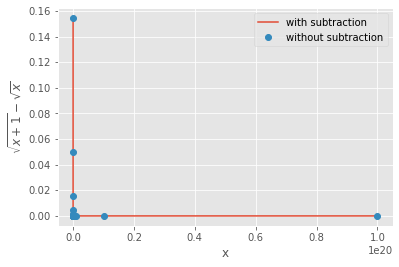

In [25]:
plt.plot(x,y1, label='with subtraction')
plt.plot(x,y2, 'o', label='without subtraction')
plt.xlabel("x")
plt.ylabel("$\sqrt{x+1} - \sqrt{x}$")
plt.legend()

What's wrong with this plot? one thig to note is that the $x$ axis clearly varies by a *lot*. Using a logarithmic plot is helpful here. Matplotlib allows log plots on the x, y, or both axes easily:

```
plt.semilogx(x,y)
plt.semilogy(x,y)
plt.loglog(x,y)
```

But even if you try that you might still not be able to see a clear difference between them. How could you fix this? *hint: it's something you learned in 107, if not before that*

Fix it, and show a plot that displays how much worse one solution is than the other. Make sure to label all axes on the plot!

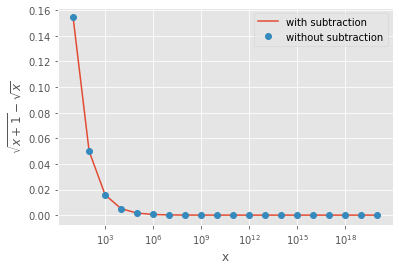

In [28]:
plt.semilogx(x,y1, label='with subtraction')
plt.semilogx(x,y2, 'o', label='without subtraction')
plt.xlabel("x")
plt.ylabel("$\sqrt{x+1} - \sqrt{x}$")
plt.legend()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


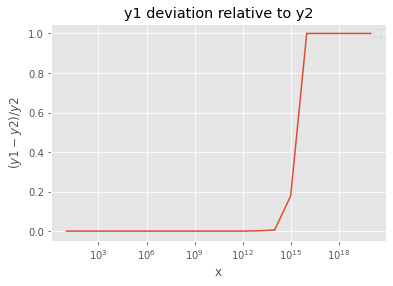

In [31]:
plt.semilogx(x,abs(y1 - y2)/y2_ls)
plt.xlabel("x")
plt.ylabel("$(y1-y2)/y2$")
plt.title("y1 deviation relative to y2")
plt.legend()

### Example 2

You need to compute the following 

$$y = \frac{\sin \theta}{\sqrt{1 - \sin^2 \theta}}$$

for $\theta \to \pi/2$. 

Your first thought is to simply solve the equation for a set of $\theta$, something like $\theta = [\pi/2 - n \epsilon, \pi/2 - (n-1) \epsilon,\pi/2 - (n-2) \epsilon\ldots,\pi/2-\epsilon]$, where $\epsilon < 1$ and $n \simeq 200$. Don't use $\theta = \pi/2$! Ask yourself why not before continuing.

First, set up your $\theta$ variable as a numpy array called `theta`. Make sure the values get closer to $\theta$. Try experimenting with different values of $\epsilon < 1$. 

In [41]:
eps = .1
theta = []
while np.pi/2 + eps != np.pi/2: # so this loop will run as long as epsilon still changes pi/2
    theta.append(np.pi/2 - eps)
    eps = eps/2.

print(theta)

[1.4707963267948965, 1.5207963267948965, 1.5457963267948966, 1.5582963267948966, 1.5645463267948965, 1.5676713267948965, 1.5692338267948966, 1.5700150767948966, 1.5704057017948965, 1.5706010142948965, 1.5706986705448966, 1.5707474986698966, 1.5707719127323965, 1.5707841197636465, 1.5707902232792716, 1.570793275037084, 1.5707948009159902, 1.5707955638554434, 1.57079594532517, 1.5707961360600333, 1.5707962314274648, 1.5707962791111807, 1.5707963029530387, 1.5707963148739676, 1.570796320834432, 1.5707963238146643, 1.5707963253047805, 1.5707963260498385, 1.5707963264223674, 1.570796326608632, 1.5707963267017644, 1.5707963267483305, 1.5707963267716134, 1.570796326783255, 1.5707963267890759, 1.5707963267919862, 1.5707963267934413, 1.570796326794169, 1.5707963267945328, 1.5707963267947147, 1.5707963267948055, 1.570796326794851, 1.570796326794874, 1.5707963267948852, 1.5707963267948908, 1.5707963267948937, 1.5707963267948952, 1.570796326794896, 1.5707963267948961]


Now that you have `theta`, compute $y$ using the above formula. 

In [60]:
y = []
i = 0
new_theta = []
# this is to make sure after all these roundings we do not divide by zero
while np.sqrt(1 - np.sin(theta[i])**2) != 0:
    y.append(np.sin(theta[i]) /np.sqrt(1 - np.sin(theta[i])**2))
    new_theta.append(theta[i])
    i += 1

print(y)

[9.966644423259181, 19.983330554894348, 39.99166631942791, 79.99583328996337, 159.99791666095294, 319.99895833138146, 639.99947916409, 1279.9997395133598, 2559.999868687987, 5119.999937212467, 10239.999946403503, 20480.00020446778, 40959.99663085979, 81919.97802124907, 163840.0781220041, 327680.15624858584, 655352.5001279806, 1310830.0138489068, 2622160.296766521, 5240321.873475328, 10480643.7469508, 21221686.142647773, 38745320.695409976, 67108863.99999999]


Now, use your knowledge of trigonometry to find an equivalent form for $y$. *Hint: it's a single trig function*

`numpy` has that function built-in. Run it on your `theta` array, and print the difference between your computed `y` and the answer given by the numpy function. This is called the "absolute error", $E_{abs} \equiv |x_{true} - x_{calc}|$.

In [62]:
y_2 = np.tan(new_theta)
print(abs(y_2 - y)) # the absolute error

[4.08562073e-14 3.76587650e-13 4.08562073e-12 3.35660388e-11
 2.84529733e-10 1.26289024e-09 2.50327048e-09 6.99353677e-08
 1.10269502e-06 2.31940248e-06 2.10473063e-05 2.20750877e-04
 3.36075045e-03 2.19739730e-02 7.81232981e-02 1.56251409e-01
 7.49980706e+00 1.10014031e+02 7.20296577e+02 2.55812606e+03
 5.11623655e+03 2.50166189e+05 3.19771935e+06 1.67772159e+07]


Now compute the *relative* error (you may have called this the "percent error" before). $E_{rel} \equiv |x_{true} - x_{calc}|/x_{true}$.

Finally, plot the *relative* error  as a function of $\theta$.

Text(0.5, 1.0, 'The Relative Error between our Different Calculations for tan(theta)')

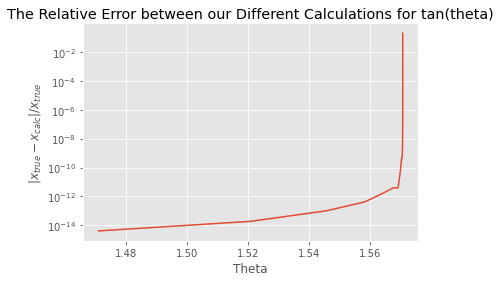

In [67]:
relative_err = abs(y_2 - y)/y_2

plt.semilogy(new_theta ,relative_err)
plt.xlabel("Theta")
plt.ylabel("$|x_{true} - x_{calc}|/x_{true}$")
plt.title("The Relative Error between our Different Calculations for tan(theta)")


**Very important note**: The *true* solution is often unknown, and in any real problem is totally unknown. If you knew the true solution, you wouldn't be bothering to run a computer simulation! It's very important for you to remember that the built in numpy function you just calculated is **also** an approximation, but in this case, it's a much, much better approximation. 

**Every computational answer is wrong, but some wrong answers are useful!**